In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor
import warnings

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()

In [196]:
train_a = pd.read_parquet('../../A/train_targets.parquet')
train_b = pd.read_parquet('../../B/train_targets.parquet')
train_c = pd.read_parquet('../../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../../C/X_test_estimated.parquet')

# Data Cleaning: Y-values

In [197]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

### Min-max scaling

In [198]:
def min_max_scaling(df, column_name='pv_measurement'):
    scaler = MinMaxScaler()
    df[column_name] = scaler.fit_transform(df[[column_name]])
    return df

train_a = min_max_scaling(train_a)
train_b = min_max_scaling(train_b)
train_c = min_max_scaling(train_c)

### Replace constants values with NaN

In [199]:
def find_repeated_rows(df):
    '''
    Returns all indicies (from, to) which have the largest intervals of being constant. The output is sorted from 
    largest to smallest.
    '''
    df = df.reset_index()
    repeated_temp = []
    intervals = []

    first = True

    for index, row in df.iterrows():
        if index == 0:
            continue
        if row['pv_measurement'] == df.iloc[index - 1]['pv_measurement']:
            repeated_temp.append(index)
            if first: 
                repeated_temp.insert(0, index - 1)
                first = False
        else:
            if len(repeated_temp) > 1:
                intervals.append((repeated_temp[0], repeated_temp[-1]))
            repeated_temp = []
            first = True

    return sorted(intervals, key=lambda t: t[1] - t[0], reverse=True)

In [200]:
def replace_constant_with_nan(dataframe, label):
    """
    Process the dataframe by replacing constant intervals with NaN.
    
    Args:
    - dataframe (pd.DataFrame): The dataframe to process.
    - label (str): The label corresponding to the dataframe.
    """
    
    intervals = find_repeated_rows(dataframe)
        
    for start, end in intervals:
        dataframe.iloc[start:end + 1, dataframe.columns.get_loc('pv_measurement')] = np.nan

    return dataframe

train_a = replace_constant_with_nan(train_a, 'A')
train_b = replace_constant_with_nan(train_b, 'B')
train_c = replace_constant_with_nan(train_c, 'C')

### Replace missing values with NaN

In [201]:
def fill_missing_dates_in_dataframe(df, frequency='H'):
    """
    Fill missing dates in the index of a dataframe with NaN values.
    
    Parameters:
    - df (DataFrame): Input dataframe with a datetime index.
    - frequency (str): Frequency string to determine the date range (default is 'H' for hourly).
    
    Returns:
    - DataFrame with filled missing dates.
    """
    
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=frequency)
    missing_dates = full_date_range.difference(df.index)
    missing_df = pd.DataFrame(index=missing_dates)
    
    return pd.concat([df, missing_df]).sort_index()


train_b = fill_missing_dates_in_dataframe(train_b)
train_c = fill_missing_dates_in_dataframe(train_c)

## Replace NaN with Y-values from dataset A

In [202]:
def replace_nans_from_source(target_df, source_df):
    """
    Replace NaN values in the 'pv_measurement' column of the target dataframe using values 
    from the 'pv_measurement' column of the source dataframe.
    
    Args:
    - target_df (pd.DataFrame): The dataframe whose 'pv_measurement' NaN values need to be replaced.
    - source_df (pd.DataFrame): The dataframe which provides the 'pv_measurement' column for replacement.
    
    Returns:
    - pd.DataFrame: The target dataframe with NaN values replaced.
    """
    target_df['pv_measurement'] = target_df['pv_measurement'].combine_first(source_df['pv_measurement'])
    return target_df

# Use the function:
train_b = replace_nans_from_source(train_b, train_a)
train_c = replace_nans_from_source(train_c, train_a)

In [203]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,NaN,1,0,0
2019-06-02 23:00:00,NaN,1,0,0
2019-06-03 00:00:00,NaN,1,0,0
2019-06-03 01:00:00,NaN,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


### Finished data cleaning for Y-values

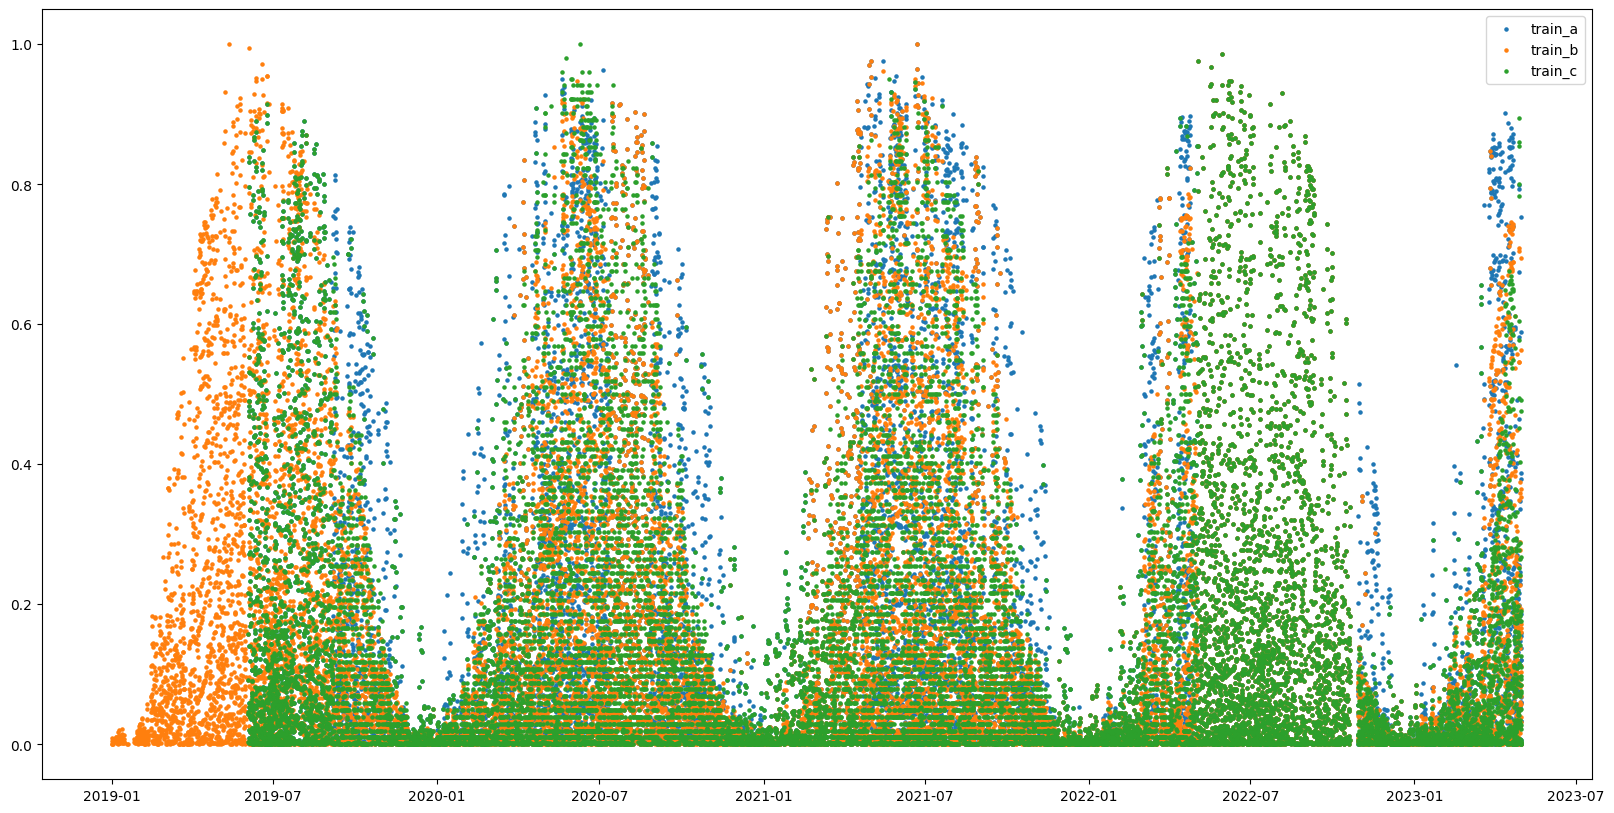

In [204]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x=train_a.index, y=train_a['pv_measurement'], s=5, label='train_a', color = color_pal[0])
ax.scatter(x=train_b.index, y=train_b['pv_measurement'], s=5, label='train_b', color = color_pal[1])
ax.scatter(x=train_c.index, y=train_c['pv_measurement'], s=5, label='train_c', color = color_pal[2])

ax.legend()
plt.show()

# Data Cleaning: X-values

### Set date_forecast as index and drop data_calc

In [205]:
all_x_train = [
    X_train_observed_a, 
    X_train_estimated_a, 
    X_train_observed_b, 
    X_train_estimated_b, 
    X_train_observed_c, 
    X_train_estimated_c
]

for df in all_x_train:
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])
    df.set_index('date_forecast', inplace=True)
    df.drop(columns="date_calc", errors="ignore", inplace=True)


### Concatenates two dataframes, adds missing date indices, and replaces NaN values

In [206]:
def concat_datasets(df1, df2):
    x = pd.concat([df1, df2], ignore_index=False)
    return x

def add_missing_dates(df):
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_dates = full_date_range.difference(df.index)
    missing_df = pd.DataFrame(index=missing_dates)
    df = pd.concat([df, missing_df]).sort_index()
    return df

def fix_dataset(obs, est):
    x = concat_datasets(obs, est)
    x = add_missing_dates(x)
    x = x.combine_first(X_train_observed_a)
    return x

x_b = fix_dataset(X_train_observed_b, X_train_estimated_b)
x_c = fix_dataset(X_train_observed_c, X_train_estimated_c)

all_x_train = [X_train_observed_a, X_train_estimated_a, x_b, x_c]

### Resampling and Labeling DataFrames

In [207]:
# Resample all DataFrames to an hourly frequency
for i in range(len(all_x_train)):
    all_x_train[i] = all_x_train[i].resample('60min').sum()

# Separate combined DataFrames
X_train_observed_a, X_train_estimated_a, x_b, x_c = all_x_train

# Label data by location
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
x_b['location'] = 'B'
x_c['location'] = 'C'

# Label data by estimated/observed status
X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
x_b['estimated'], x_b.loc[x_b.index > X_train_estimated_b.index.min(), 'estimated'] = 0, 1
x_c['estimated'], x_c.loc[x_c.index > X_train_estimated_c.index.min(), 'estimated'] = 0, 1


### Combining DataFrames and One-hot Encoding

In [208]:
# Combine all DataFrames and sort by index
X = pd.concat(all_x_train, ignore_index=False)
X = X.sort_index()

# One-hot encode location information
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

### Merging Data with Target Data and Setting Index

In [209]:
# Merge processed data with target data
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

# Set and sort the index
df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()

### Feature Engineering

In [210]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

df = create_features(df)


# XGBoost

In [ ]:
cv_split = TimeSeriesSplit(n_splits=5)
model = XGBRegressor()

parameters = {
    "max_depth": [3, 4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "n_estimators": [100, 300, 500, 700, 900, 1000],
    "colsample_bytree": [0.3, 0.5, 0.7]
}

X_train = df[FEATURES]
y_train = df[TARGET]

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters, verbose=2)
grid_search.fit(X_train, y_train)
